In [1]:
#!pip install numpy
#!pip install pandas
#!pip install tensorflow
#!pip install keras
#!pip install spacy
#!python -m spacy download en_core_web_sm

# Thư viện cần thiết

In [42]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing import sequence
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from numpy import array,asarray,zeros
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import tensorflow as tf
tf.random.set_seed(4)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Đọc, hiển thị và kiểm tra tập dữ liệu

In [3]:
df = pd.read_csv("D:/TTCS/data/IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
#Kiểm tra các giá trị bị thiếu
null_values = df.isnull().sum()
null_values.index[0]
print('Có {} giá trị bị thiếu cho {} và {} giá trị bị thiếu cho {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))

Có 0 giá trị bị thiếu cho review và 0 giá trị bị thiếu cho sentiment.


In [7]:
# Kiểm tra các giá trị trùng lặp
num_duplicates = df.duplicated().sum() 
print('Có {} bài đánh giá trùng lặp trong tập dữ liệu'.format(num_duplicates))

Có 418 bài đánh giá trùng lặp trong tập dữ liệu


In [8]:
#xem các bài đánh giá trùng lặp
review = df['review']
duplicated_review = df[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


In [9]:
# Bỏ các bài đánh giá trùng lặp
df.drop_duplicates(inplace = True)
print('Tập dữ liệu chứa {} hàng và {} cột sau khi loại bỏ trùng lặp'.format(df.shape[0],df.shape[1]))

Tập dữ liệu chứa 49582 hàng và 2 cột sau khi loại bỏ trùng lặp


# Trực quan

In [10]:
# Gán nhãn số cho sentiment
df.sentiment = [ 1 if each == "positive" else 0 for each in df.sentiment]
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


<AxesSubplot:title={'center':'Số lượng mục tiêu cho các bài đánh giá IMDB'}, xlabel='sentiment', ylabel='count'>

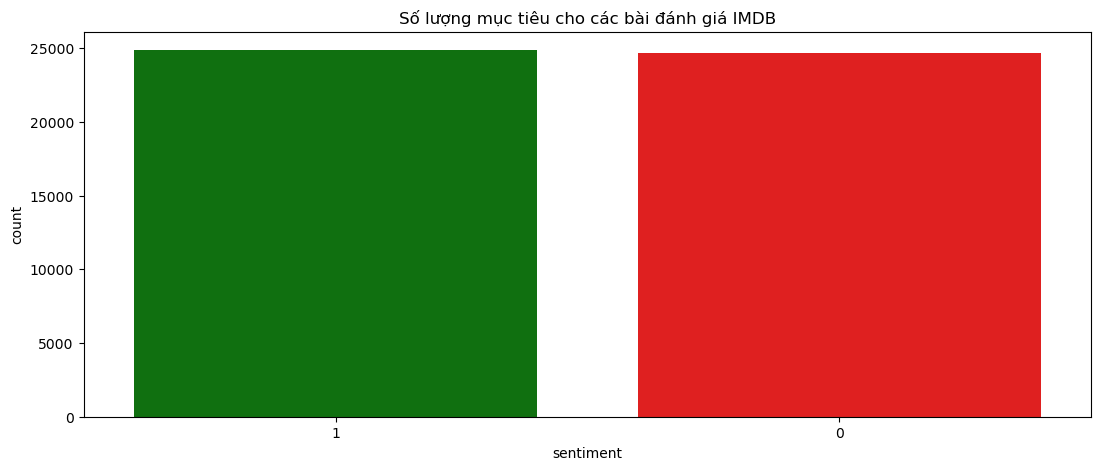

In [11]:
plt.figure(figsize=(13,5))
plt.title('Số lượng mục tiêu cho các bài đánh giá IMDB')
sns.countplot(x='sentiment',data=df, palette=['green', 'red'], order=[1, 0])

# Tiền xử lý văn bản cho 1 câu

In [12]:
ex1 = df['review'].loc[5]
ex1

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

In [13]:
# Xóa thẻ HTML
soup = BeautifulSoup(ex1, "html.parser")
ex1 = soup.get_text() 
ex1

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

In [14]:
# Sử dụng Biểu thức chính quy để xóa kí tự đặc biệt
ex1 = re.sub('\[[^]]*\]', ' ',ex1)
ex1 = re.sub('[^a-zA-Z]', ' ',ex1)
ex1

'Probably my all time favorite movie  a story of selflessness  sacrifice and dedication to a noble cause  but it s not preachy or boring  It just never gets old  despite my having seen it some    or more times in the last    years  Paul Lukas  performance brings tears to my eyes  and Bette Davis  in one of her very few truly sympathetic roles  is a delight  The kids are  as grandma says  more like  dressed up midgets  than children  but that only makes them more fun to watch  And the mother s slow awakening to what s happening in the world and under her own roof is believable and startling  If I had a dozen thumbs  they d all be  up  for this movie '

In [15]:
# Chuyển qua từ thường(LowerCase)
ex1 = ex1.lower()
ex1

'probably my all time favorite movie  a story of selflessness  sacrifice and dedication to a noble cause  but it s not preachy or boring  it just never gets old  despite my having seen it some    or more times in the last    years  paul lukas  performance brings tears to my eyes  and bette davis  in one of her very few truly sympathetic roles  is a delight  the kids are  as grandma says  more like  dressed up midgets  than children  but that only makes them more fun to watch  and the mother s slow awakening to what s happening in the world and under her own roof is believable and startling  if i had a dozen thumbs  they d all be  up  for this movie '

In [16]:
# Tách từ (split)
ex1 = ex1.split()
ex1

['probably',
 'my',
 'all',
 'time',
 'favorite',
 'movie',
 'a',
 'story',
 'of',
 'selflessness',
 'sacrifice',
 'and',
 'dedication',
 'to',
 'a',
 'noble',
 'cause',
 'but',
 'it',
 's',
 'not',
 'preachy',
 'or',
 'boring',
 'it',
 'just',
 'never',
 'gets',
 'old',
 'despite',
 'my',
 'having',
 'seen',
 'it',
 'some',
 'or',
 'more',
 'times',
 'in',
 'the',
 'last',
 'years',
 'paul',
 'lukas',
 'performance',
 'brings',
 'tears',
 'to',
 'my',
 'eyes',
 'and',
 'bette',
 'davis',
 'in',
 'one',
 'of',
 'her',
 'very',
 'few',
 'truly',
 'sympathetic',
 'roles',
 'is',
 'a',
 'delight',
 'the',
 'kids',
 'are',
 'as',
 'grandma',
 'says',
 'more',
 'like',
 'dressed',
 'up',
 'midgets',
 'than',
 'children',
 'but',
 'that',
 'only',
 'makes',
 'them',
 'more',
 'fun',
 'to',
 'watch',
 'and',
 'the',
 'mother',
 's',
 'slow',
 'awakening',
 'to',
 'what',
 's',
 'happening',
 'in',
 'the',
 'world',
 'and',
 'under',
 'her',
 'own',
 'roof',
 'is',
 'believable',
 'and',
 'sta

In [17]:
# Xử lí từ dừng(stopword)
ex1 = [word for word in ex1 if not word in set(stopwords.words('english'))]
ex1

['probably',
 'time',
 'favorite',
 'movie',
 'story',
 'selflessness',
 'sacrifice',
 'dedication',
 'noble',
 'cause',
 'preachy',
 'boring',
 'never',
 'gets',
 'old',
 'despite',
 'seen',
 'times',
 'last',
 'years',
 'paul',
 'lukas',
 'performance',
 'brings',
 'tears',
 'eyes',
 'bette',
 'davis',
 'one',
 'truly',
 'sympathetic',
 'roles',
 'delight',
 'kids',
 'grandma',
 'says',
 'like',
 'dressed',
 'midgets',
 'children',
 'makes',
 'fun',
 'watch',
 'mother',
 'slow',
 'awakening',
 'happening',
 'world',
 'roof',
 'believable',
 'startling',
 'dozen',
 'thumbs',
 'movie']

In [18]:
# Lemmatization/WordNetLemmatizer(Đưa về từ gốc)
lem = WordNetLemmatizer()
ex1 = [lem.lemmatize(word) for word in ex1]
ex1

['probably',
 'time',
 'favorite',
 'movie',
 'story',
 'selflessness',
 'sacrifice',
 'dedication',
 'noble',
 'cause',
 'preachy',
 'boring',
 'never',
 'get',
 'old',
 'despite',
 'seen',
 'time',
 'last',
 'year',
 'paul',
 'lukas',
 'performance',
 'brings',
 'tear',
 'eye',
 'bette',
 'davis',
 'one',
 'truly',
 'sympathetic',
 'role',
 'delight',
 'kid',
 'grandma',
 'say',
 'like',
 'dressed',
 'midget',
 'child',
 'make',
 'fun',
 'watch',
 'mother',
 'slow',
 'awakening',
 'happening',
 'world',
 'roof',
 'believable',
 'startling',
 'dozen',
 'thumb',
 'movie']

In [19]:
# Nối lại các từ(join)
ex1 = ' '.join(ex1)
ex1

'probably time favorite movie story selflessness sacrifice dedication noble cause preachy boring never get old despite seen time last year paul lukas performance brings tear eye bette davis one truly sympathetic role delight kid grandma say like dressed midget child make fun watch mother slow awakening happening world roof believable startling dozen thumb movie'

# Chia tập dữ liệu

In [20]:
x_train, x_test, y_train, y_test= train_test_split(df['review'], df['sentiment'], test_size=0.25, random_state=42)
y_train = (y_train.replace({'positive': 1, 'negative': 0})).values
y_test  = (y_test.replace({'positive': 1, 'negative': 0})).values
print(y_train)
print(y_test)

[1 1 1 ... 0 1 1]
[0 1 0 ... 0 0 0]


# Tiền xử lý cho tập dữ liệu

In [21]:
imdb_train = []
for i in range(x_train.shape[0]):
    soup = BeautifulSoup(x_train.iloc[i], "html.parser")
    review = soup.get_text()
    review = re.sub('\[[^]]*\]', ' ', review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    lem = WordNetLemmatizer()
    review = [lem.lemmatize(word) for word in review]
    review = ''.join(review)
    imdb_train.append(review)

D:\anaconda\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [22]:
imdb_test  = []
for j in range(x_test.shape[0]):
    soup = BeautifulSoup(x_test.iloc[j], "html.parser")
    review = soup.get_text()
    review = re.sub('\[[^]]*\]', ' ', review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    lem = WordNetLemmatizer()
    review = [lem.lemmatize(word) for word in review]
    review = ''.join(review)
    imdb_test.append(review)

# Xây dựng mô hình

In [23]:
# Tạo một đối tượng để lập chỉ mục từ điển từ mô đun tokenizer 
# Mỗi từ được sử dụng làm khóa trong khi chỉ mục duy nhất tương ứng và được sử dụng làm giá trị cho khóa.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
# Vecto hoá 
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [24]:
x_train
x_test

[[1289,
  1518,
  6,
  3,
  489,
  596,
  29,
  208,
  12,
  61,
  142,
  1352,
  83,
  16,
  3931,
  525,
  2,
  7,
  7,
  1,
  111,
  6,
  21,
  61,
  3665,
  18,
  81,
  692,
  3079,
  112,
  6,
  665,
  1417,
  1417,
  2306,
  16,
  3,
  1179,
  4,
  541,
  2,
  2091,
  102,
  1344,
  8,
  17,
  74,
  4046,
  611,
  23,
  403,
  2127,
  1463,
  2,
  218,
  109,
  56,
  3,
  226,
  1128,
  11,
  15,
  1486,
  99,
  2408,
  2,
  6,
  365,
  4,
  3990,
  2040,
  12,
  204,
  25,
  460,
  153,
  56,
  8,
  1,
  1,
  61,
  147,
  9,
  65,
  45,
  165,
  17,
  9,
  6,
  47,
  177,
  2131,
  18,
  65,
  43,
  22,
  178,
  12,
  22,
  67,
  834,
  137,
  35,
  1,
  1221,
  2430,
  585,
  7,
  7,
  10,
  67,
  1010,
  62,
  231,
  134,
  5,
  378,
  238,
  473,
  239,
  25,
  3,
  166,
  3,
  125,
  2,
  57,
  3198,
  16,
  3,
  38,
  38,
  867,
  7,
  7,
  236,
  156],
 [2959,
  35,
  1,
  722,
  695,
  3,
  1418,
  63,
  4,
  57,
  2076,
  1796,
  933,
  4,
  49,
  2,
  478,
  30,
  16,
 

In [25]:
do_dai_danhsach_x = [len(i) for i in x_train + x_test]
print(f'Độ dài tối đa của câu:{max(do_dai_danhsach_x)}')
print(f'Độ dài trung bình của câu:{np.mean(do_dai_danhsach_x)}')

Độ dài tối đa của câu:2117
Độ dài trung bình của câu:211.72713888104553


D:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


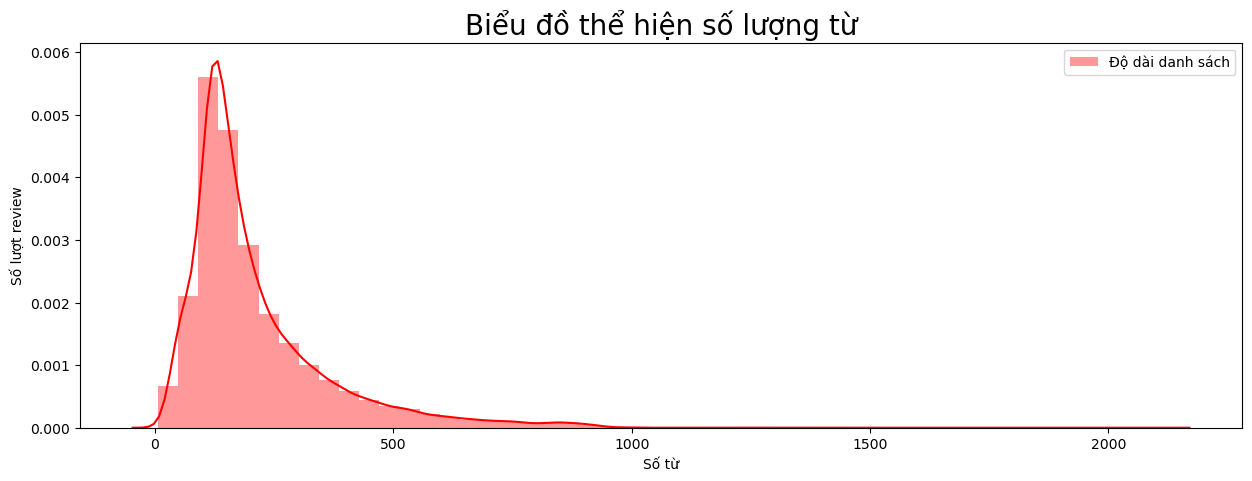

In [26]:
# Sử dụng seaborn để vẽ độ dài câu
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(do_dai_danhsach_x, color='red',label="Độ dài danh sách")
plt.title('Biểu đồ thể hiện số lượng từ',fontsize=20,color='black')
ax.legend()
ax.set(xlabel='Số từ',ylabel='Số lượt review')
plt.show()

In [27]:
vocabulary_size = len(tokenizer.word_index) + 1
maxlength = 100

x_train_padding = pad_sequences(x_train, padding="post",maxlen=maxlength, truncating="post")
x_test_padding = pad_sequences(x_test, padding="post",maxlen=maxlength, truncating="post")
# Kiểm tra danh sách ngẫu nhiên trong X_train  có cùng độ dài là 100
len(x_train[3])

245

In [28]:
# Kiểm tra 
x_train_padding

array([[  32,  394,    1, ...,  774,    7,    7],
       [ 198,  292,    3, ...,    8,  170,   95],
       [  76,   11,   19, ...,    8,    3, 2636],
       ...,
       [1026, 1026,    7, ...,    2,  304,   47],
       [  11,  354,   13, ...,    0,    0,    0],
       [  11,    6,    3, ...,   36, 2160,   30]])

In [29]:
x_train_padding.shape

(37186, 100)

In [30]:
vocabulary_size

108952

In [31]:
tudien_duoc_nhung = dict()
glove_file = open('D:/TTCS/data/glove.6B.100d.txt',encoding='utf-8')
for line in glove_file:
    record = line.split()
    word = record[0]
    kich_thuoc = asarray(record[1:], dtype = "float32")
    tudien_duoc_nhung[word] = kich_thuoc
glove_file.close()

In [32]:
ma_tran_nhung = zeros((vocabulary_size , 100))
for word, index in tokenizer.word_index.items():
    vecto_nhung = tudien_duoc_nhung.get(word)
    if vecto_nhung is not None:
        ma_tran_nhung[index, :] = vecto_nhung 

In [33]:
vecto_nhung

In [34]:
ma_tran_nhung

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.28059   , -0.027038  ,  0.073588  , ...,  0.16734   ,
        -0.54356998,  0.2061    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# Mô hình

In [35]:
mo_hinh = Sequential()
lop_nhung = Embedding(vocabulary_size, 100, weights=[ma_tran_nhung], input_length=maxlength, trainable=False)
mo_hinh.add(lop_nhung)
mo_hinh.add(Conv1D(128, 2, activation='relu'))
mo_hinh.add(Conv1D(128, 3, activation='relu'))
mo_hinh.add(Conv1D(128, 4, activation='relu'))
mo_hinh.add(GlobalMaxPooling1D())
mo_hinh.add(Dropout(0.2))
mo_hinh.add(Flatten())
mo_hinh.add(Dense(64, activation='tanh'))
mo_hinh.add(Dropout(0.5))
mo_hinh.add(Dense(2, activation='softmax'))
mo_hinh.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mo_hinh.add(Dense(1, activation='sigmoid'))
mo_hinh.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(mo_hinh.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          10895200  
                                                                 
 conv1d (Conv1D)             (None, 99, 128)           25728     
                                                                 
 conv1d_1 (Conv1D)           (None, 97, 128)           49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 94, 128)           65664     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

# Huấn luyện và đánh giá mô hình

In [36]:
history = mo_hinh.fit(x_train_padding, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
233/233 [==============================] - 43s 168ms/step - loss: 0.6935 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 2/10
233/233 [==============================] - 39s 168ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 3/10
233/233 [==============================] - 39s 166ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5015
Epoch 4/10
233/233 [==============================] - 39s 167ms/step - loss: 0.6582 - accuracy: 0.6310 - val_loss: 0.6217 - val_accuracy: 0.7194
Epoch 5/10
233/233 [==============================] - 39s 167ms/step - loss: 0.5803 - accuracy: 0.7537 - val_loss: 0.5535 - val_accuracy: 0.7724
Epoch 6/10
233/233 [==============================] - 39s 167ms/step - loss: 0.5434 - accuracy: 0.7706 - val_loss: 0.5311 - val_accuracy: 0.7775
Epoch 7/10
233/233 [==============================] - 39s 167ms/step - loss: 0.5146 - accuracy: 0.7863 - val_loss: 0.5179 - val_ac

In [37]:
# dự đoán mô hình
du_doan_y = mo_hinh.predict(x_test_padding)
du_doan_y = np.round(du_doan_y).astype(int)
print(classification_report(y_test,du_doan_y))

388/388 [==============================] - 8s 19ms/step
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      6168
           1       0.82      0.75      0.78      6228

    accuracy                           0.79     12396
   macro avg       0.79      0.79      0.79     12396
weighted avg       0.79      0.79      0.79     12396



In [38]:
accuracy_score = mo_hinh.evaluate(x_test_padding, y_test, verbose = 1)

388/388 [==============================] - 7s 18ms/step - loss: 0.4813 - accuracy: 0.7915


In [39]:
# Kiểm tra độ chính xác
print("Test Score: {:.2%}".format(accuracy_score[0]))
print("Test Accuracy: {:.2%}".format(accuracy_score[1]))

Test Score: 48.13%
Test Accuracy: 79.15%


# Tạo đánh giá ngẫu nhiên

In [40]:
index = np.random.randint(x_train_padding.shape[1])
ex = imdb_train[index]
print(ex)

higherlearningslapfaceuclosetlongregardlessethnicbackgroundsubjectuwouldlikeignorecannotaffordrealprogressivechangewayableembraceunderstanddiversitycriticizedfilmhatefuldumbfactmatterignorancereignsupremeworldseveralcontinuehelpdominatesocietyeveryoneinvolvedfilmdonegooddeedshowingstepmustcontinuedoneordermakeanymorefilmlikehigherlearningsuresoundlikepipedreamstartsomewherehelp


In [41]:
ex = tokenizer.texts_to_sequences(ex)
ds = []
for e in ex:
    for i in e:
        ds.append(i)
ds = [ds]
ex = pad_sequences(ds, padding = 'post', maxlen = maxlength)
mo_hinh.predict(ex)

1/1 [==============================] - 0s 47ms/step


array([[0.8152231]], dtype=float32)